In [1]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import mahalanobis
from sklearn.covariance import MinCovDet
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Ellipse
import scipy.stats

In [2]:
# Read the dataset from a CSV file
dat = pd.read_csv('./Input/df_phon.csv').sort_values(by='row_index')
dat_append = pd.read_csv('./Input/dat_append.csv').sort_values(by='row_index')

# Drop the 'row_index', 'speaker', and 'time' columns from the additional dataset
dat_append = dat_append.drop(columns=['row_index', 'speaker', 'time'])

# Concatenate the two dataframes along the columns after resetting their indices
df = pd.concat([dat.reset_index(drop=True), dat_append.reset_index(drop=True)], axis=1)

# Display the final dataframe
df

,speaker,previous,segment,following,onset,offset,dur,previousWord,word,followingWord,...,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12
0,CA1HA_87,NaN,i,a,299.63,300.05,0.42,NaN,y,además,...,0,0,0,0,0,0,0,0,0,0
1,CA1HA_87,i,a,ð,300.05,300.12,0.07,y,además,además,...,0,0,0,0,0,0,0,0,0,0
2,CA1HA_87,a,ð,e,300.12,300.20,0.08,y,además,además,...,0,0,0,0,0,0,0,0,0,0
3,CA1HA_87,ð,e,m,300.20,300.26,0.06,y,además,además,...,0,0,0,0,0,0,0,0,0,0
4,CA1HA_87,e,m,a,300.26,300.33,0.07,y,además,además,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5648,CA1HA_87,s,i,n,895.55,895.58,0.03,ir,sin,que,...,0,0,0,0,0,0,0,0,0,0
5649,CA1HA_87,i,n,e,895.58,895.67,0.09,ir,sin,que,...,0,0,0,0,0,0,0,0,0,0
5650,CA1HA_87,n,e,ʝ,895.67,895.78,0.11,sin,ella,que,...,0,0,0,0,0,0,0,0,0,0
5651,CA1HA_87,e,ʝ,a,895.78,895.85,0.07,sin,ella,que,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Convert the 'dur' column from seconds to milliseconds and store it in a new column 'duration_ms'
df['duration_ms'] = df['dur'] * 1000

# Filter out rows where 'formant_1', 'formant_2', or 'formant_3' columns start with '--'
df = df[~df['formant_1'].astype(str).str.startswith('--')]
df = df[~df['formant_2'].astype(str).str.startswith('--')]
df = df[~df['formant_3'].astype(str).str.startswith('--')]

# Convert 'formant_1', 'formant_2', and 'formant_3' columns to numeric data type
df['formant_1'] = pd.to_numeric(df['formant_1'])
df['formant_2'] = pd.to_numeric(df['formant_2'])
df['formant_3'] = pd.to_numeric(df['formant_3'])

# Filter the dataframe to include only rows where 'segment_type_segments' is 'vowel'
df = df[df['segment_type_segments'] == 'vowel']


In [4]:
def find_outliers(df, columns, keep=0.95, verbose=False):
    # Subset the dataframe to the specified columns
    data_for_mahal = df[columns].to_numpy()
    n_vars = data_for_mahal.shape[1]

    # Get the length of the data
    total_n = len(data_for_mahal)
    # Figure out how many to remove
    n_to_remove = int(np.floor(total_n * (1-keep)))

    # Initialize the is_outlier column
    is_outlier = np.zeros(total_n, dtype=bool)

    # Don't do anything for small groups
    if n_to_remove == 0:
        if verbose:
            print(f"With only {total_n} tokens, there are not enough tokens to determine outliers.")
    else:
        # Loop through and remove the points one at a time
        for _ in range(n_to_remove):
            # Subset to non-outliers
            non_outliers = data_for_mahal[~is_outlier]

            # Use the MinCovDet for robust covariance estimation
            mcd = MinCovDet().fit(non_outliers)
            center = mcd.location_
            cov = mcd.covariance_

            # Compute Mahalanobis distance
            mahal_dist = np.array([mahalanobis(row, center, np.linalg.inv(cov)) for row in non_outliers])

            # Find the index of the point with the largest distance
            outlier_idx = np.argmax(mahal_dist)

            # Mark that point as an outlier
            is_outlier[np.where(~is_outlier)[0][outlier_idx]] = True

    return is_outlier

# Create a 'segmentid' column for grouping
df['segmentid'] = df['segment']

# Function to apply the find_outliers function to each group
def apply_find_outliers(group):
    outliers = find_outliers(group, ['formant_1', 'formant_2'])
    return pd.Series(outliers, index=group.index)

# Apply the find_outliers function to each group
df['is_outlier'] = df.groupby(['segmentid', 'speaker']).apply(apply_find_outliers).reset_index(level=[0, 1], drop=True)

# Filter out outliers
df_filtered = df[~df['is_outlier']]

# Display the filtered dataframe
df_filtered

C:\Users\srika\AppData\Local\Temp\ipykernel_79636\2420393119.py:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['is_outlier'] = df.groupby(['segmentid', 'speaker']).apply(apply_find_outliers).reset_index(level=[0, 1], drop=True)


,speaker,previous,segment,following,onset,offset,dur,previousWord,word,followingWord,...,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,duration_ms,segmentid,is_outlier
0,CA1HA_87,NaN,i,a,299.63,300.05,0.42,NaN,y,además,...,0,0,0,0,0,0,0,420.0,i,False
1,CA1HA_87,i,a,ð,300.05,300.12,0.07,y,además,además,...,0,0,0,0,0,0,0,70.0,a,False
3,CA1HA_87,ð,e,m,300.20,300.26,0.06,y,además,además,...,0,0,0,0,0,0,0,60.0,e,False
5,CA1HA_87,m,a,s,300.33,300.38,0.05,y,además,además,...,0,0,0,0,0,0,0,50.0,a,False
7,CA1HA_87,s,e,l,300.43,300.46,0.03,además,el,además,...,0,0,0,0,0,0,0,30.0,e,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5644,CA1HA_87,s,i,i,895.29,895.36,0.07,caracas,y,que,...,0,0,0,0,0,0,0,70.0,i,False
5645,CA1HA_87,i,i,ɾ,895.36,895.39,0.03,y,ir,que,...,0,0,0,0,0,0,0,30.0,i,False
5648,CA1HA_87,s,i,n,895.55,895.58,0.03,ir,sin,que,...,0,0,0,0,0,0,0,30.0,i,False
5650,CA1HA_87,n,e,ʝ,895.67,895.78,0.11,sin,ella,que,...,0,0,0,0,0,0,0,110.0,e,False


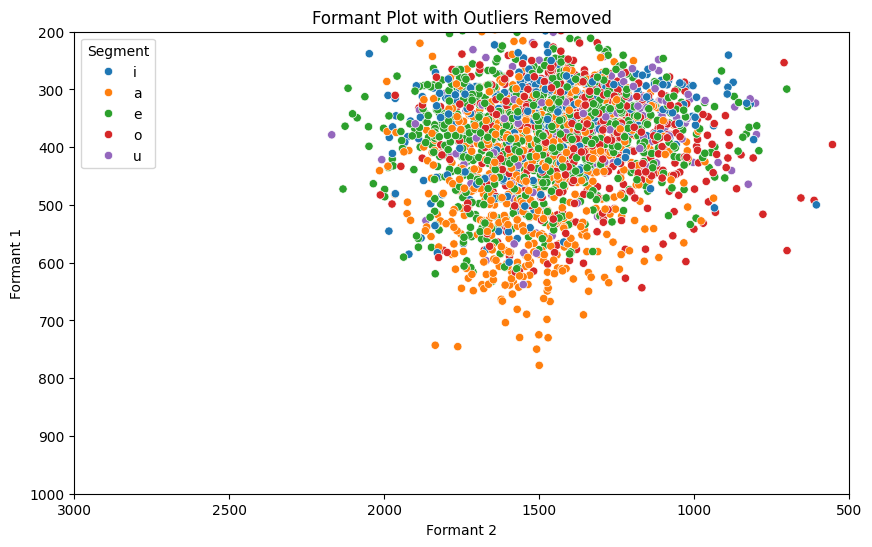

In [5]:
# Create a new figure with specified size
plt.figure(figsize=(10, 6))

# Create a scatter plot of formant_2 vs. formant_1, colored by 'segment'
sns.scatterplot(data=df_filtered, x='formant_2', y='formant_1', hue='segment')

# Reverse the x and y axes
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

# Set the limits for the x and y axes
plt.xlim(3000, 500)
plt.ylim(1000, 200)

# Set the labels for the x and y axes
plt.xlabel('Formant 2')
plt.ylabel('Formant 1')

# Set the title of the plot
plt.title('Formant Plot with Outliers Removed')

# Display the legend with the title 'Segment'
plt.legend(title='Segment')

# Show the plot
plt.show()

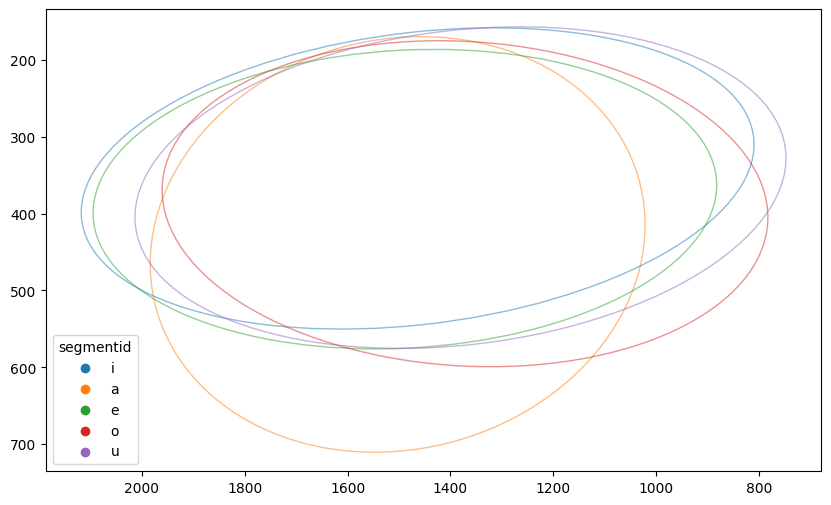

In [6]:
# Function to plot data points with confidence ellipses
def plot_with_ellipse(data, x, y, hue, confidence=0.95, alpha=0.5):
    plt.figure(figsize=(10, 6))
    ax = plt.gca()

    # Generate a color palette for the unique values of the hue column
    unique_hues = data[hue].unique()
    palette = sns.color_palette(n_colors=len(unique_hues))
    color_dict = dict(zip(unique_hues, palette))

    # Create an empty scatter plot for the legend
    for name in unique_hues:
        ax.scatter([], [], color=color_dict[name], label=name)

    # Group the data by the hue column
    groups = data.groupby(hue)
    for name, group in groups:
        # Calculate the mean and covariance matrix for each group
        mean_x, mean_y = group[x].mean(), group[y].mean()
        cov = np.cov(group[x], group[y])

        # Compute eigenvalues and eigenvectors of the covariance matrix
        eigvals, eigvecs = np.linalg.eigh(cov)
        angle = np.degrees(np.arctan2(*eigvecs[:,0][::-1]))

        # Calculate the width and height of the ellipse based on the chi-squared distribution
        chisq_val = np.sqrt(scipy.stats.chi2.ppf(confidence, df=2))
        width, height = 2 * chisq_val * np.sqrt(eigvals)

        # Create an ellipse patch and add it to the plot
        ellipse = Ellipse(xy=(mean_x, mean_y), width=width, height=height, angle=angle,
                          edgecolor=color_dict[name], facecolor='none', alpha=alpha)
        ax.add_patch(ellipse)

    # Reverse the x and y axes limits
    ax.set_xlim(ax.get_xlim()[::-1])
    ax.set_ylim(ax.get_ylim()[::-1])

    # Display the legend with the title set to the hue column name
    ax.legend(title=hue)
    
    # Show the plot
    plt.show()

# Call the function to plot the data with ellipses
plot_with_ellipse(df_filtered, 'formant_2', 'formant_1', 'segmentid')

In [7]:
# Create a copy of the filtered dataframe
df2 = df_filtered.copy()

# Create new columns 'F1' and 'F2' based on 'formant_1' and 'formant_2'
df2['F1'] = df2['formant_1']
df2['F2'] = df2['formant_2']

# Add a 'gender' column based on the 'speaker' column (assuming 'H' in speaker indicates Male, otherwise Female)
df2['gender'] = df2['speaker'].apply(lambda x: 'Male' if 'H' in x else 'Female')

# Create another copy of the dataframe
dat_filtered = df2.copy()

# Add a 'context' column with a sequence of numbers starting from 1
dat_filtered['context'] = range(1, len(dat_filtered) + 1)

# Create a new DataFrame 'dnorm' with the specified columns
dnorm = dat_filtered[['speaker', 'segment', 'context', 'formant_1', 'formant_2', 'formant_3', 'formant_1', 'formant_2', 'formant_3']]

# Rename the columns to new names
dnorm.columns = ['speaker_id', 'vowel_id', 'context', 'F1', 'F2', 'F3', 'F1_glide', 'F2_glide', 'F3_glide']

# Set specific columns 'F3', 'F1_glide', 'F2_glide', and 'F3_glide' to NaN
dnorm.loc[:, 'F3'] = np.nan
dnorm.loc[:, 'F1_glide'] = np.nan
dnorm.loc[:, 'F2_glide'] = np.nan
dnorm.loc[:, 'F3_glide'] = np.nan

# Display the first few rows of the 'dnorm' DataFrame
dnorm.head()

,speaker_id,vowel_id,context,F1,F2,F3,F1_glide,F2_glide,F3_glide
0,CA1HA_87,i,1,287.566144,874.971623,NaN,NaN,NaN,NaN
1,CA1HA_87,a,2,420.261539,1260.644591,NaN,NaN,NaN,NaN
3,CA1HA_87,e,3,543.267135,1823.585422,NaN,NaN,NaN,NaN
5,CA1HA_87,a,4,333.337285,1626.919275,NaN,NaN,NaN,NaN
7,CA1HA_87,e,5,516.892476,1706.254111,NaN,NaN,NaN,NaN


In [8]:
# Function to perform Lobanov normalization on formant data
def lobanov_normalize(df):
    # Extract the formant columns F1 and F2
    formants = df[['F1', 'F2']]
    
    # Calculate the mean and standard deviation for each formant
    means = np.mean(formants, axis=0)
    stds = np.std(formants, axis=0)
    
    # Normalize the formants using the mean and standard deviation
    normalized_formants = (formants - means) / stds

    normalized_formants['context'] = df['context']

    # Return the normalized DataFrame along with the means and standard deviations
    return normalized_formants

# Create a DataFrame from the 'dnorm' data
dnorm_df = pd.DataFrame(dnorm)

# Normalize formants using the Lobanov method
normed_vowels = lobanov_normalize(dnorm_df)

# Display the normalized vowels DataFrame
normed_vowels

,F1,F2,context
0,-1.116957,-2.408717,1
1,0.277222,-0.817562,2
3,1.569594,1.504940,3
5,-0.636058,0.693562,4
7,1.292486,1.020871,5
...,...,...,...
5644,-0.589106,0.324958,2394
5645,-1.231347,-0.191299,2395
5648,-1.513002,0.013844,2396
5650,0.087105,0.181887,2397


In [9]:
def scale_vowels(df):
    # Define column names for formants
    f1_col = 'F1'
    f2_col = 'F2'

    # Find minimum and maximum values for F1 and F2 columns
    min_f1 = df[f1_col].min()
    max_f1 = df[f1_col].max()
    min_f2 = df[f2_col].min()
    max_f2 = df[f2_col].max()

    # Create an empty DataFrame for scaled values
    scaled = pd.DataFrame()

    # Scale F1 values to a new range (250 to 750)
    scaled[f1_col] = round((500 * (df[f1_col] - min_f1) / (max_f1 - min_f1)) + 250, 3)

    # Scale F2 values to a new range (850 to 2200)
    scaled[f2_col] = round((1400 * (df[f2_col] - min_f2) / (max_f2 - min_f2)) + 850, 3)
    
    # Add the 'context' column to the scaled DataFrame
    scaled['context'] = df['context']

    return scaled

# Apply the scaling function to the DataFrame 'normed_vowels'
rescaled = scale_vowels(normed_vowels)

# Display the column names of the rescaled DataFrame
rescaled.columns


Index(['F1', 'F2', 'context'], dtype='object')

In [10]:
# Rename columns in the 'normed_vowels' DataFrame to indicate normalized values
normed_vowels.rename(columns={
    'F1': 'F1_norm',  # Rename F1 to F1_norm
    'F2': 'F2_norm',  # Rename F2 to F2_norm
}, inplace=True)

# Rename columns in the 'rescaled' DataFrame to indicate scaled values
rescaled.rename(columns={
    'F1': 'F1_sc',  # Rename F1 to F1_sc
    'F2': 'F2_sc',  # Rename F2 to F2_sc
}, inplace=True)

# Merge 'dat_filtered' with 'normed_vowels' and 'rescaled' DataFrames on 'context'
dat_normalised = dat_filtered.merge(normed_vowels, on='context')\
                              .merge(rescaled, on='context')

# Save the 'dat_normalised_2' DataFrame to a CSV file without row names
dat_normalised.to_csv('./Output/icphs_a_data.csv', index=False)

# Display the merged DataFrame 'dat_normalised'
dat_normalised


,speaker,previous,segment,following,onset,offset,dur,previousWord,word,followingWord,...,segmentid,is_outlier,F1,F2,gender,context,F1_norm,F2_norm,F1_sc,F2_sc
0,CA1HA_87,NaN,i,a,299.63,300.05,0.42,NaN,y,además,...,i,False,287.566144,874.971623,Male,1,-1.116957,-2.408717,377.880,1127.627
1,CA1HA_87,i,a,ð,300.05,300.12,0.07,y,además,además,...,a,False,420.261539,1260.644591,Male,2,0.277222,-0.817562,478.624,1461.895
2,CA1HA_87,ð,e,m,300.20,300.26,0.06,y,además,además,...,e,False,543.267135,1823.585422,Male,3,1.569594,1.504940,572.012,1949.804
3,CA1HA_87,m,a,s,300.33,300.38,0.05,y,además,además,...,a,False,333.337285,1626.919275,Male,4,-0.636058,0.693562,412.630,1779.351
4,CA1HA_87,s,e,l,300.43,300.46,0.03,además,el,además,...,e,False,516.892476,1706.254111,Male,5,1.292486,1.020871,551.988,1848.111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2393,CA1HA_87,s,i,i,895.29,895.36,0.07,caracas,y,que,...,i,False,337.806103,1537.574860,Male,2394,-0.589106,0.324958,416.023,1701.915
2394,CA1HA_87,i,i,ɾ,895.36,895.39,0.03,y,ir,que,...,i,False,276.678748,1412.441692,Male,2395,-1.231347,-0.191299,369.614,1593.460
2395,CA1HA_87,s,i,n,895.55,895.58,0.03,ir,sin,que,...,i,False,249.871388,1462.165333,Male,2396,-1.513002,0.013844,349.262,1636.556
2396,CA1HA_87,n,e,ʝ,895.67,895.78,0.11,sin,ella,que,...,e,False,402.166609,1502.896506,Male,2397,0.087105,0.181887,464.887,1671.858


Text(0.5, 1.0, 'Mean Duration by Segment')

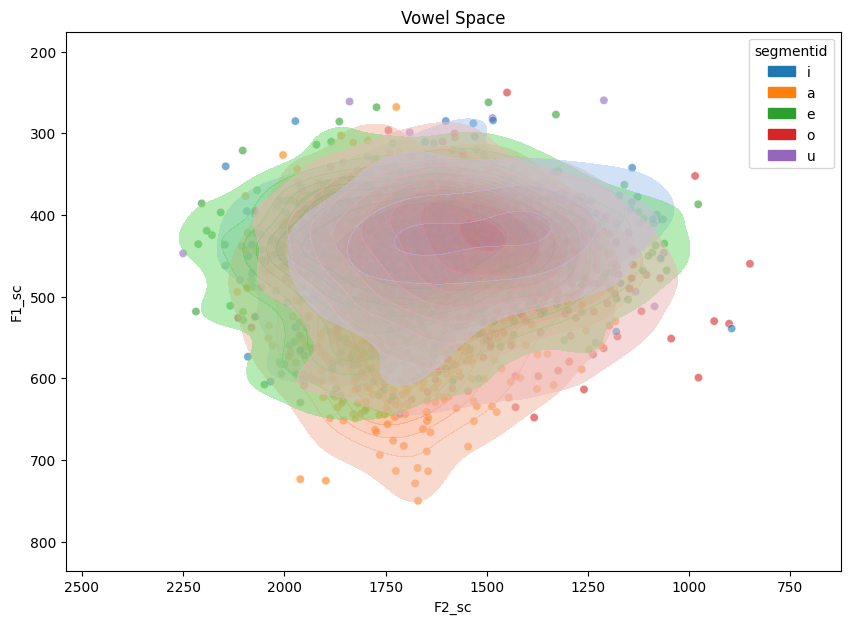

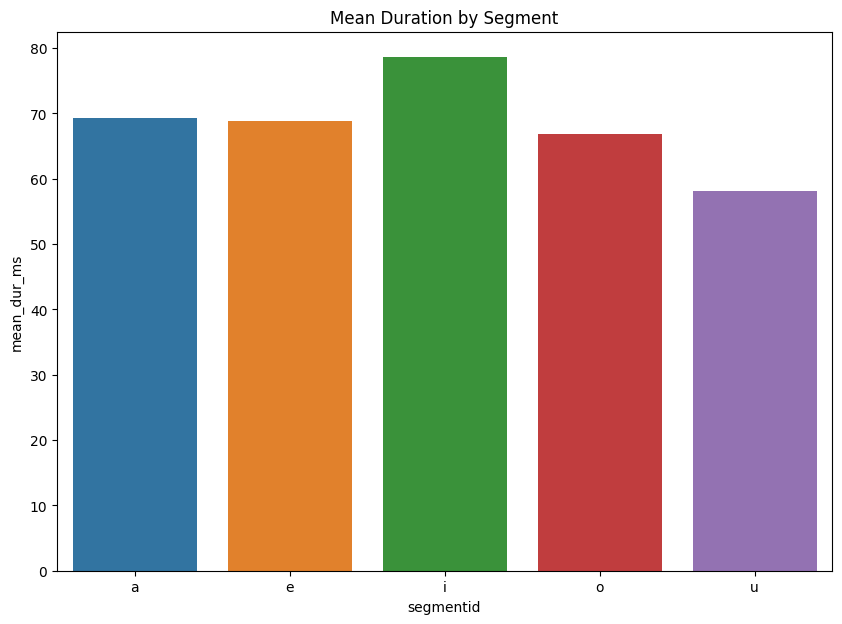

In [11]:
# Plotting the vowel space
plt.figure(figsize=(10, 7))  # Set the size of the figure
# Scatter plot of F2 vs. F1 with color coding by 'segmentid'
sns.scatterplot(data=dat_normalised, x='F2_sc', y='F1_sc', hue='segmentid', alpha=0.6)
# Kernel Density Estimate (KDE) plot for F2 vs. F1 with color coding by 'segmentid'
sns.kdeplot(data=dat_normalised, x='F2_sc', y='F1_sc', hue='segmentid', fill=True, alpha=0.5)
# Invert the x-axis and y-axis to match typical vowel space plots
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.title('Vowel Space')  # Title for the vowel space plot

# Save the vowel space plot as a JPG file
# plt.savefig('vowelSpace.jpg', dpi=300, bbox_inches='tight')

# Summarize mean duration and plot
# Group by 'segmentid' and calculate the mean duration
mean_duration = dat_normalised.groupby('segmentid')['duration_ms'].mean().reset_index()
mean_duration.columns = ['segmentid', 'mean_dur_ms']  # Rename the duration column

plt.figure(figsize=(10, 7))  # Set the size of the figure
# Bar plot of mean duration by 'segmentid'
sns.barplot(data=mean_duration, x='segmentid', y='mean_dur_ms', hue='segmentid', dodge=False)
plt.title('Mean Duration by Segment')  # Title for the mean duration plot
# Save the mean duration plot as a JPG file
#plt.savefig('durationPlots.jpg', dpi=300, bbox_inches='tight')
